# Applying Time Series Regression to Ocean Gauge Data

Christopher Liu 

Contact: cmhl@uw.edu

Last change - 9/18/2020, added scaling for the feature dataframes

-----
[tsfresh](https://tsfresh.readthedocs.io/) is required to run this notebook

In [1]:
%matplotlib inline

In [2]:
import numpy as np

from scipy.interpolate import interp1d

from pylab import *
from IPython.display import Image

np.set_printoptions(threshold=1000) # edit as needed

## Plots

Plots of the original uninterpolated data. Time series, slip on fault and surface deformation. Only contains runs 600-699

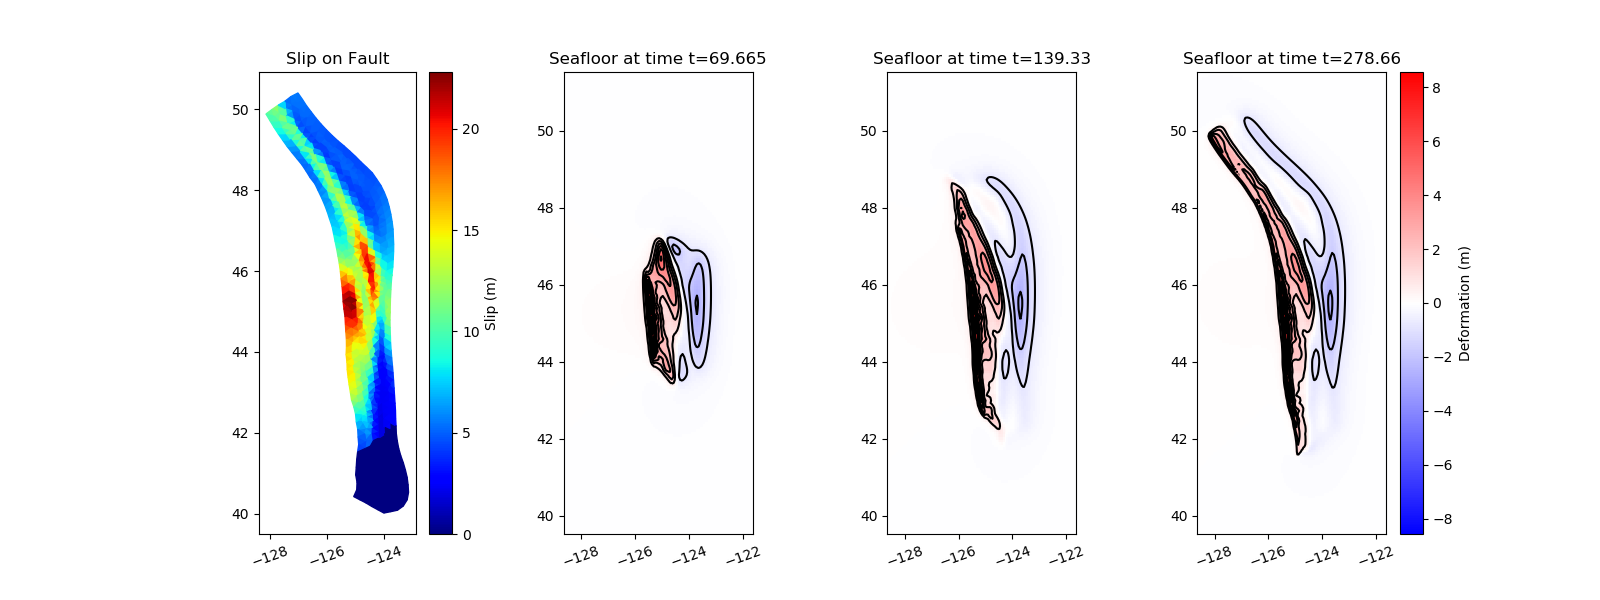

In [3]:
rnum = 1297   # run number
dtopo_png = 'C:/Users/Chris/Desktop/SJDF_files/dtopo/cascadia%s.png' % str(rnum).zfill(6)
Image(dtopo_png, width=900)

In [4]:
# (Un)comment as needed

# rnums = range(608,609)
# etamax = {}

# figure(figsize=(12,6))
# for rnum in rnums:
#     outdir = 'C:/Users/Chris/Desktop/SJDF_files/gauges/run_%s/_output' % str(rnum).zfill(6)
#     #print('outdir = ', outdir)

#     gaugenos = [702]
#     for gaugeno in gaugenos:
#         gfile = '%s/gauge%s.txt' % (outdir, str(gaugeno).zfill(5))
#         gdata = loadtxt(gfile)
#         t = gdata[:,1] / 60.  # minutes
#         eta = gdata[:,5]  # surface elevation in meters
#         plot(t, eta, label='Run # %s' % rnum)
#         etamax[(rnum,gaugeno)] = eta.max()

# xlim(0, 360)
# xlabel('Minutes after quake')
# ylabel('Surface elevation (meters) and scaled momenutm')
# grid(True)
# legend()

# Load Data

Loads the interpolated time series data. This step can be skipped if loading the features/data frame directly

In [5]:
rnums = range(0,1300)
gaugenos = [702,712,901,902,911,912]

eta = {}
t = {}
for rnum in rnums:
    outdir = 'C:/Users/Chris/Desktop/gauge_data/run_%s/' % str(rnum).zfill(6)
    
    for gaugeno in gaugenos:
        gfile = '%s/gauge%s.txt' % (outdir, str(gaugeno).zfill(5))
        g_data = np.genfromtxt(gfile, delimiter=',')
        
        # data in this case has a NaN value for eta @ t=0
        t[(rnum,gaugeno)] = g_data[1:,0]  # seconds

        eta[(rnum,gaugeno)] = g_data[1:,1]  # surface elevation in meters

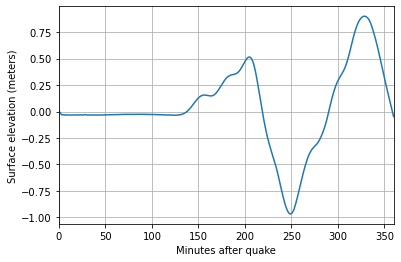

In [488]:
# Code for plotting some of the data. (Un)comment as needed

gnum = 911
rnum = 1000

plot(t[(rnum,gnum)]/60,eta[(rnum,gnum)])

xlim(0, 360)
xlabel('Minutes after quake')
ylabel('Surface elevation (meters)')
grid(True)

# Featurize

In [7]:
import pandas as pd

from sklearn.preprocessing import StandardScaler

from tsfresh import extract_features, select_features
from tsfresh.feature_selection import relevance
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters

In [8]:
def max_eta(data,gaugeno,runs):
    """
    Finds the max eta for a specific gauge and run(s)
    Input:
        data - Dictionary of timeseries data with the form: data[(run_number, gauge_number)]
        gaugeno - Integer gauge number
        runs - List or range of run numbers to find the max value for
    
    Output:
        eta_max - np array containing the maximum values.
    """
    eta_max = []
    for rnum in runs:
        eta_max.append(np.amax(data[(rnum,gaugeno)]))
    return np.array(eta_max)

In [9]:
def get_thresh(data,threshold):
    """
    Finds index of time series when threshold is met or exceeded
    Input:
        data - Numpy array of time series
        threshold - int/double that each entry in the time series is compared against 
        
    Returns:
        i - Integer index of time series when threshold is met or exceeded
            OR
        math.nan - Returns NaN if threshold is not met/exceeded
    """
    for i in range(len(data)):
        if np.abs(data[i]) >= threshold:
            return i
    return math.nan

In [10]:
def stack_series(data, time, gaugeno, runs, threshold, tsteps, subs_thresh, subs_time):
    
    """
    Stacks the time series used to construct the dataframe for feature extraction with thresholding.
    Input:
        data - Dictionary of eta data with the form: data[(run_number, gauge_number)]
        time - Dictionary of time intervals of the form: time[(run_number, gauge_number)]
        gaugeno - Integer gauge number
        runs - Integer total number of runs
        threshold - int/double that each entry in the time series is compared against 
        tsteps - Number of time steps to extract after threshold is met
        subs_thresh - Threshold for average initial subsidence
        subs_time - Time steps over which the average subsidence is taken
        
    Returns:
        g - Stacked eta time series of the form [(Run#0000,Gauge#702),(Run#0001,Gauge#702), ..., (Run#1299,Gauge#702)]
        run_id - ID used to identify which run number the time series belongs to, ranges from 0 to 1299
        runs_used - List containing the run numbers used (met the threshold). Not used for feature extraction
        times - The time scale/interval corresponding to an eta time series
        tstart - The indices where each time series met or exceeded the threshold. Not used for feature extraction
    """
    rnums = range(0,runs)
    
    runs_used = []
    g = []
    times = []
    run_id = []
    tstart = []
    
    for rnum in rnums:
        g_data = data[(rnum,gaugeno)]
        t_data = time[(rnum,gaugeno)]
        ind = get_thresh(g_data,threshold) #returns NaN if threshold is not met/exceeded
        
        if math.isnan(ind) == False and np.average(g_data[0:subs_time]) > subs_thresh: #ignore run if NaN
            runs_used.append(rnum)
            tstart.append(ind)
            
            #checking to see if there is enough data after threshold is met/exceeded
            if ind+tsteps < len(g_data):
                g.extend(g_data[ind:ind+tsteps].tolist())
                times.extend(t_data[ind:ind+tsteps].tolist())
                run_id.extend((np.ones(tsteps)*rnum).tolist())
            else:
                g.extend(g_data[ind:].tolist())
                times.extend(t_data[ind:].tolist())
                run_id.extend((np.ones(len(g_data)-ind)*rnum).tolist())

    return g, run_id, runs_used, times, tstart

In [11]:
def stack_series_all(data, time, gaugeno, runs):
    """
    Stacks the time series used to construct the dataframe for feature extraction without thresholding.
    Input:
        data - Dictionary of eta data with the form: data[(run_number, gauge_number)]
        time - Dictionary of time intervals of the form: time[(run_number, gauge_number)]
        gaugeno - Integer gauge number
        runs - Integer total number of runs
        
    Returns:
        g - Stacked eta time series of the form [(Run#0000,Gauge#702),(Run#0001,Gauge#702), ..., (Run#1299,Gauge#702)]
        run_id - ID used to identify which run number the time series belongs to, ranges from 0 to 1299
        times - The time scale/interval corresponding to an eta time series
    """
    
    rnums = range(0,runs)
    
    g = []
    times = []
    run_id = []
    
    for rnum in rnums:
        g_data = data[(rnum,gaugeno)]
        t_data = time[(rnum,gaugeno)]
        
        g.extend(g_data.tolist())
        times.extend(t_data.tolist())
        run_id.extend((np.ones(len(g_data))*rnum).tolist())

    return g, run_id, times

In [12]:
def max_eta_all(data,gaugeno,runs):
    """
    Finds the max eta for all runs and a specific gauge 
    Input:
        data - Dictionary of timeseries data with the form: data[(run_number, gauge_number)]
        gaugeno - Integer gauge number
        runs - Number of runs
    
    Output:
        eta_max - np array containing the maximum values.
    """
    eta_max = []
    for rnum in range(runs):
        eta_max.append(np.amax(data[(rnum,gaugeno)]))
    return np.array(eta_max)

In [13]:
def normalize(df):
    """
    Normalizes each column so that they have 0 mean and unit variance. Refer to documentation of StandardScaler for more
    details.
    Input:
        df - Dataframe of features created by tsfresh
    
    Output:
        scaled: Dataframe where each column is scaled to have a 0 mean and unit variance.
    """
    scaler = StandardScaler()
    scaled = df.copy()
    scaled[scaled.columns] = scaler.fit_transform(scaled[scaled.columns])
    
    return scaled

In [431]:
tsteps = 361 # 60 minutes
threshold = 0.1
sub_thresh = -20000 # set to arbitrarily large negative number if you do not want to filter for subsidence
sub_time = 31

eta_g702, run_id, runs_used, times, tstart = stack_series(eta, t, 702, 1300, threshold, tsteps, sub_thresh, sub_time)

In [432]:
len(runs_used)

1157

#### Histogram of when time when threshold is met/exceeded

Text(0, 0.5, 'Frequency')

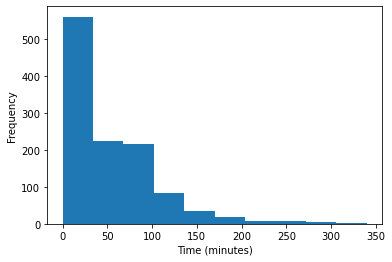

In [433]:
plt.hist(np.array(tstart)*(1/6))
plt.xlabel('Time (minutes)')
plt.ylabel('Frequency')

### Create dataframe and extract features
Skip if loading features from a .csv

In [434]:
dict = {'id':run_id, 'time':times, 'eta': eta_g702}
df = pd.DataFrame(dict)

# export datafrane used for feature extraction 
# df.to_csv(r'GaugeData1hr_818.csv', index=False) 

In [435]:
# This takes awhile to run. Keep commented if you are worried about accidentally running all cells. 

 feat702 = extract_features(df, column_id='id', column_sort='time',
                            default_fc_parameters=ComprehensiveFCParameters(), impute_function=impute)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 10/10 [02:05<00:00, 12.52s/it]


In [436]:
# drop constant features
print(feat702.shape)
feat702 = feat702.loc[:, feat702.apply(pd.Series.nunique) != 1] 
print(feat702.shape)

(1157, 763)
(1157, 717)


### Import/Export feature dataframe
Comment/Uncomment as needed

In [437]:
# importing or exporting features to save computation time

# export features
# feat702.to_csv(r'feat702_all_910.csv', index=False)

# import features
# feat702 = pd.read_csv (r'feat702_all_910.csv')

### Creating/loading the max eta for desired gauges
Comment/uncomment the relevant block

In [438]:
# Creating/loading the max eta for desired gauges

# find max eta for gauges

g901max = max_eta(eta,901,runs_used)
g902max = max_eta(eta,902,runs_used)
g911max = max_eta(eta,911,runs_used)
g912max = max_eta(eta,912,runs_used)

# find max eta for gauges, all runs

# g901max = max_eta_all(eta,901,1300)
# g902max = max_eta_all(eta,902,1300)
# g911max = max_eta_all(eta,911,1300)
# g912max = max_eta_all(eta,912,1300)

# load max eta for gauges

# g901max = np.loadtxt('g901max.csv', delimiter=',')
# g902max = np.loadtxt('g902max.csv', delimiter=',')
# g911max = np.loadtxt('g911max.csv', delimiter=',')
# g912max = np.loadtxt('g912max.csv', delimiter=',')

# save max eta for gauges

# savetxt('g901max.csv', g901max, delimiter=',')
# savetxt('g902max.csv', g912max, delimiter=',')
# savetxt('g911max.csv', g901max, delimiter=',')
# savetxt('g912max.csv', g912max, delimiter=',')

### Filter features

Refer to https://tsfresh.readthedocs.io/en/latest/text/feature_filtering.html for more info. (Un)comment relevant block as needed

In [439]:
# Features without scaling
feat702_filt901 = select_features(feat702,g901max,ml_task='regression')
feat702_filt902 = select_features(feat702,g902max,ml_task='regression')
feat702_filt911 = select_features(feat702,g911max,ml_task='regression')
feat702_filt912 = select_features(feat702,g912max,ml_task='regression')

# Features with standard scaling
# feat702_filt901 = normalize(select_features(feat702,g901max,ml_task='regression'))
# feat702_filt902 = normalize(select_features(feat702,g902max,ml_task='regression'))
# feat702_filt911 = normalize(select_features(feat702,g911max,ml_task='regression'))
# feat702_filt912 = normalize(select_features(feat702,g912max,ml_task='regression'))

## Build and Test Model

In [440]:
from sklearn.svm import SVR
from sklearn.metrics import explained_variance_score

In [441]:
# Inputs and some constants and used for training and visualization

# Uncomment this if using all runs (no thresholding)
# runs_used = np.arange(1300)

numruns = len(runs_used)
testsize = 0.4

unfilt_df = feat702 # change between normalized df and unscaled df for unfiltered models.

rseed = 1 # random seed used for train/test split

In [442]:
def train_test_split(data, target, runs_used, test_size, seed):
    """
    Splits data and target into training and testing sets for a given random seed. Keeps track of which runs are
    put into training and testing sets.
    
    Input
        data - Dataframe of data samples
        target - np array of targets
        runs_used - np array of run numbers used
        test_size - test size as a fraction of the total samples (between 0 and 1)
        seed - seed used for random number generator
    Output
        train - Dataframe of training data
        test - Dataframe of testing data
        train_target - np array of training targets
        test_target - np array of testing targets
        train_runs - np array of run numbers in training data
        test_runs - np array of run numbers in testing data
    
    """
    
    
    np.random.seed(seed)
    
    total = len(target)
    
    tt_size = np.round(total*test_size)
    tr_size = int(total - tt_size)
    
    perm = np.random.permutation(total)
    
    train = data.iloc[perm[:tr_size]]
    train_target = target[perm[0:tr_size]]
    train_runs = runs_used[perm[0:tr_size]]
    
    test = data.iloc[perm[tr_size:]]
    test_target = target[perm[tr_size:]]
    test_runs = runs_used[perm[tr_size:]]
    
    return train, test, train_target, test_target, train_runs, test_runs

In [443]:
def plot_test(target,pred,line):
    """
    Plots the predicted versus actual value along with a reference line of slope 1.
    
    Input
        target - Target values
        pred - Predicted values
        line - Endpoint of reference line
    
    """
    figure(figsize=(13,7))
    
    plt.plot(target,pred,'r.')
    plot([0,line],[0,line],'k--')
    
    xlabel('Max eta (Actual)')
    ylabel('Max eta (Predicted)')
    grid(True)

### Train Models

### Gauge 901

#### Unfiltered

In [444]:
train_901, test_901, train_901_target, test_901_target, train_901_runs, test_901_runs = \
    train_test_split(unfilt_df, g901max, np.asarray(runs_used), test_size=testsize,seed=rseed)

In [445]:
# Train model for gauge 901 using unfilited data. rbf and scale are default parameters
regress901 = SVR(kernel='rbf',gamma='scale')
regress901.fit(train_901, train_901_target, sample_weight=None)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

#### Filtered

In [446]:
train_901_f, test_901_f, train_901_f_target, test_901_f_target, train_901_f_runs, test_901_f_runs = \
    train_test_split(feat702_filt901, g901max, np.asarray(runs_used), test_size=testsize, seed=rseed)

In [447]:
#Train model for gauge 901 using filtered data. rbf and scale are default parameters
regress901_f = SVR(kernel='rbf',gamma='scale')
regress901_f.fit(train_901_f, train_901_f_target, sample_weight=None)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

### Gauge 902

#### Unfiltered

In [448]:
train_902, test_902, train_902_target, test_902_target, train_902_runs, test_902_runs = \
    train_test_split(unfilt_df, g902max,np.asarray(runs_used), test_size=testsize, seed=rseed)

In [449]:
regress902 = SVR(kernel='rbf',gamma='scale')
regress902.fit(train_902, train_902_target, sample_weight=None)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

#### Filtered

In [450]:
train_902_f, test_902_f, train_902_f_target, test_902_f_target, train_902_f_runs, test_902_f_runs \
    = train_test_split(feat702_filt902, g902max, np.asarray(runs_used), test_size=testsize, seed=rseed)

In [451]:
#Train model for gauge 902 using filtered data. rbf and scale are default parameters
regress902_f = SVR(kernel='rbf',gamma='scale')
regress902_f.fit(train_902_f, train_902_f_target, sample_weight=None)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

### Gauge 911

#### Unfiltered

In [452]:
train_911, test_911, train_911_target, test_911_target, train_911_runs, test_911_runs \
    = train_test_split(unfilt_df, g911max, np.asarray(runs_used), test_size=testsize, seed=rseed)

In [453]:
#Train model for gauge 911 using unfilited data. rbf and scale are default parameters
regress911= SVR(kernel='rbf',gamma='scale')
regress911.fit(train_911, train_911_target, sample_weight=None)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

#### Filtered

In [454]:
train_911_f, test_911_f, train_911_f_target, test_911_f_target, train_911_f_runs, test_911_f_runs \
    = train_test_split(feat702_filt911, g911max, np.asarray(runs_used), test_size=testsize, seed=rseed)

In [455]:
# Train model for gauge 911 using filtered data. rbf and scale are default parameters
regress911_f = SVR(kernel='rbf',gamma='scale')
regress911_f.fit(train_911_f, train_911_f_target, sample_weight=None)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

### Gauge 912

#### Unfiltered

In [456]:
train_912, test_912, train_912_target, test_912_target, train_912_runs, test_912_runs \
    = train_test_split(unfilt_df, g912max, np.asarray(runs_used), test_size=testsize, seed=rseed)

In [457]:
#Train model for gauge 912 using unfilited data. rbf and scale are default parameters
regress912 = SVR(kernel='rbf',gamma='scale')
regress912.fit(train_912, train_912_target, sample_weight=None)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

#### Filtered

In [458]:
train_912_f, test_912_f, train_912_f_target, test_912_f_target, train_912_f_runs, test_912_f_runs \
    = train_test_split(feat702_filt912, g912max, np.asarray(runs_used), test_size=testsize, seed=rseed)

In [459]:
#Train model for gauge 912 using filtered data. rbf and scale are default parameters
regress912_f = SVR(kernel='rbf',gamma='scale')
regress912_f.fit(train_912_f, train_912_f_target, sample_weight=None)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

### Test Model and Plot Results

#### 901

0.8673437632400611

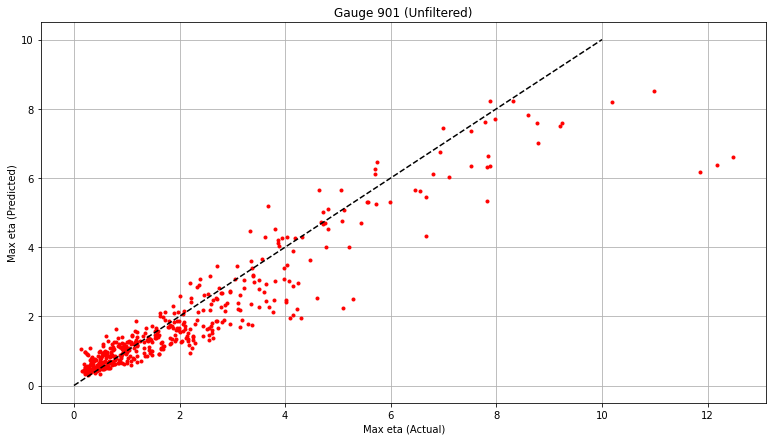

In [460]:
pred_901 = regress901.predict(test_901)

plot_test(test_901_target,pred_901,10)
plt.legend
title('Gauge 901 (Unfiltered)')
plt.savefig('g901_subs.png')

explained_variance_score(test_901_target,pred_901)

0.8602992169002568

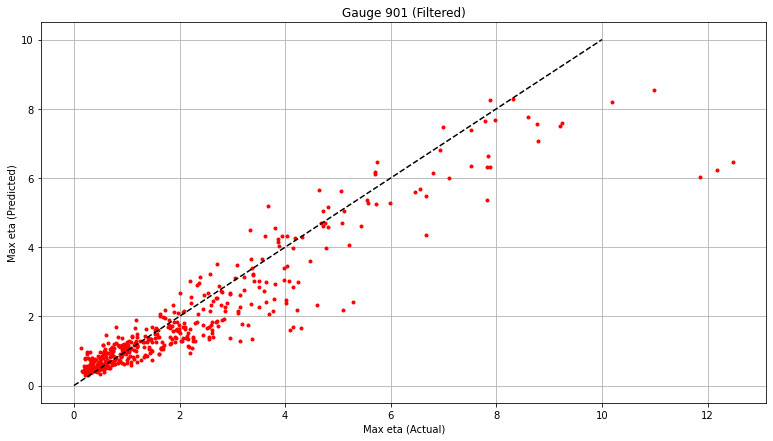

In [461]:
pred_901_f = regress901_f.predict(test_901_f)

plot_test(test_901_f_target,pred_901_f,10)
title('Gauge 901 (Filtered)')
plt.savefig('g901_f_subs.png')

explained_variance_score(test_901_f_target,pred_901_f)

#### 902

0.8799862282281649

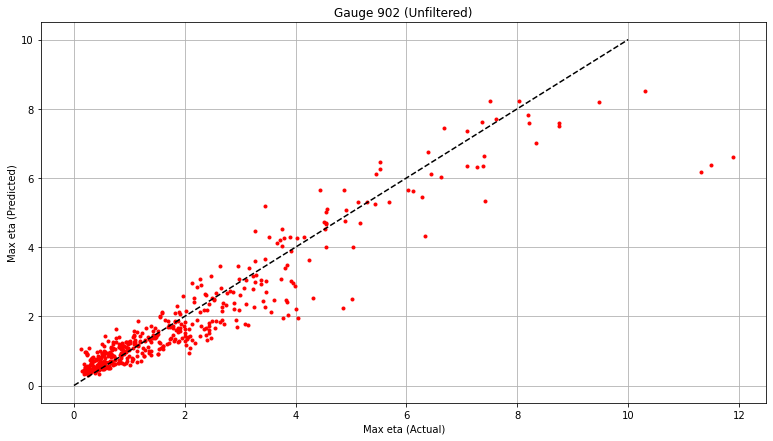

In [462]:
pred_902 = regress901.predict(test_902)

plot_test(test_902_target,pred_902,10)
title('Gauge 902 (Unfiltered)')
plt.savefig('g902_subs.png')

explained_variance_score(test_902_target,pred_902)

0.870968120494446

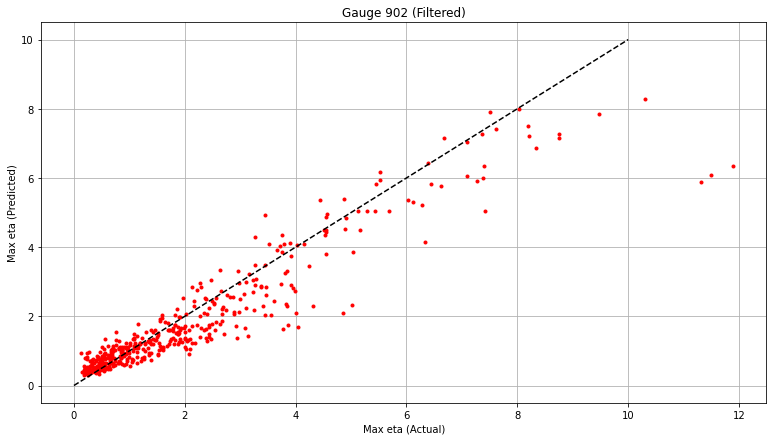

In [463]:
pred_902_f = regress902_f.predict(test_902_f)

plot_test(test_902_f_target,pred_902_f,10)
title('Gauge 902 (Filtered)')
plt.savefig('g902_f_subs.png')

explained_variance_score(test_902_f_target,pred_902_f)

#### 911

0.9361954815296785

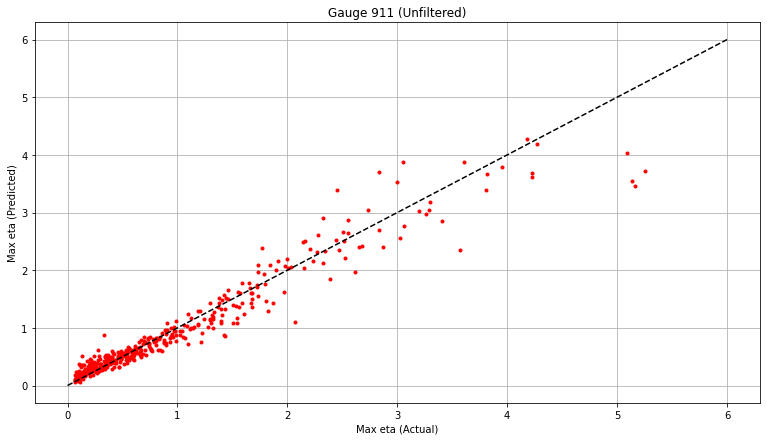

In [464]:
pred_911 = regress911.predict(test_911)

plot_test(test_911_target,pred_911,6)
title('Gauge 911 (Unfiltered)')
plt.savefig('g911_subs.png')

explained_variance_score(test_911_target,pred_911)

0.9333740484899501

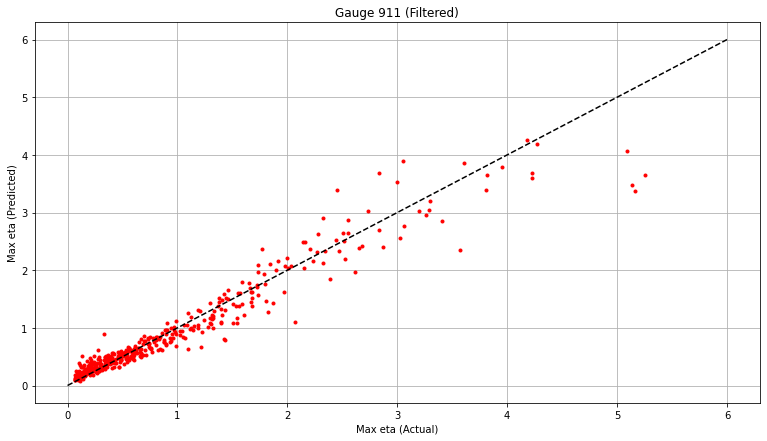

In [465]:
pred_911_f = regress911_f.predict(test_911_f)

plot_test(test_911_f_target,pred_911_f,6)
title('Gauge 911 (Filtered)')
plt.savefig('g911_f_subs.png')

explained_variance_score(test_911_f_target,pred_911_f)

#### 912

0.920553985922029

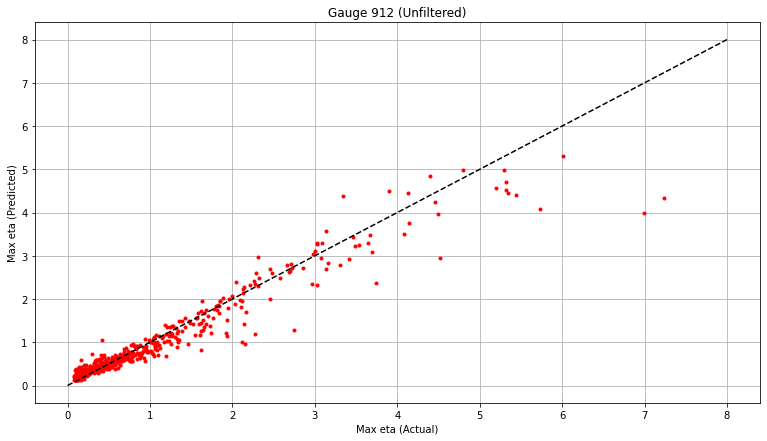

In [466]:
pred_912 = regress912.predict(test_912)

plot_test(test_912_target,pred_912,8)
title('Gauge 912 (Unfiltered)')
plt.savefig('g912_subs.png')

explained_variance_score(test_912_target,pred_912)

0.9166630736311571

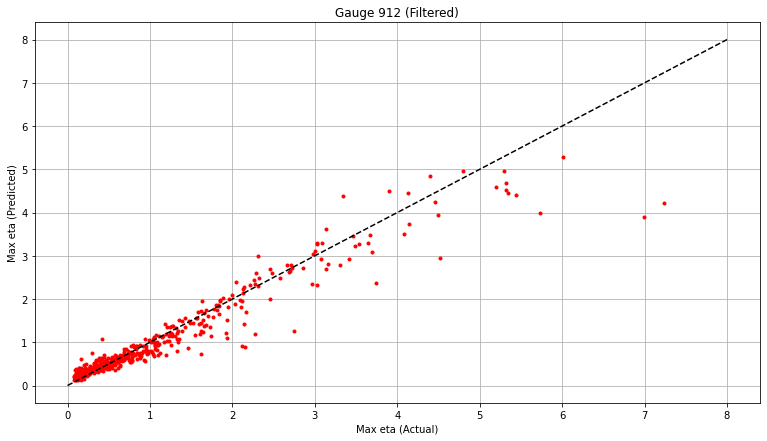

In [467]:
pred_912_f = regress912_f.predict(test_912_f)

plot_test(test_912_f_target,pred_912_f,8)
title('Gauge 912 (Filtered)')
plt.savefig('g912_f_subs.png')

explained_variance_score(test_912_f_target,pred_912_f)

## Plotting Specific Runs

Code used for finding the run numbers of the most inaccurate predictions and plotting them. This section requires the interpolated data to be loaded.

In [468]:
def find_inacc_runs(pred, target, runs, n):
    
    """
        Finds runs of the n largest absolute difference between predicted and actual and outputs a pandas dataframe. 

        Input:
               pred - Prediction from regression model
               target - Actual max eta value
               runs - run numbers used for the testing set
               n - number of largest absolute differences returned
               
        Output:
            pd.Dataframe - pandas datafram containing the run numbers, predicted and actual eta, and absolute difference
                           of predicted and actual.
    """
    
    difference = np.abs(pred-target)
    ind = difference.argsort()[-n:][::-1]
    
    run_dict = {'Run Number' : np.array(runs)[ind], 'Predicted' : pred[ind], 'Actual' : target[ind], 
                    'Abs Diff': difference[ind]}
    
    return pd.DataFrame(data = run_dict)
    

In [469]:
def find_run(pred, target, runs, run_num):
    """
    Prints predicted and actual max eta for a specified run. 

    Input:
           pred - Prediction from regression model
           target - Actual max eta value
           runs - run numbers used for the testing set
           run_num - specified run number

    """

    ind = np.where(runs == run_num)
    
    if len(ind[0]) == 1:
        print("Run Number:" + str(run_num) + ", Predicted:" + str(pred[ind]) + ", Actual:" + str(target[ind]))
    else:
        print("Run not found.")

In [470]:
def plot_run(rnum, gaugeno, *pred):
    
    """
       Plots gauge 702 and a specified 9XX gauge for a specified run number
       
       Input:
           rnum - Run number of interest
           gaugeno - Gauge number of interest
           *pred - optional argument for printing predicted value on title of plot
    """
    
    fig, (ax1, ax2) = plt.subplots(2,sharex=True, sharey=True,figsize=(12,10))
    
    title = 'Run # %s' % rnum
    
    if pred:
        title =title + ', Predicted: %sm' % np.around(pred[0],2)
    
    ax1.set_title(title, fontsize=20,)
    
    fig.add_subplot(111, frameon=False) # used for centering the y-axis label
    
    ax1.plot(t[(rnum,702)]/60, eta[(rnum,702)], label="Gauge # 702", color='blue')
    ax1.grid(True)
    ax1.legend(loc='upper left')
    
    
    #Plot window of data used and reference line for threshold. 
    start = tstart[runs_used.index(rnum)]*10
    end = (start + (tsteps-1)*10)
    ax1.axvline(start/60, color ='red', ls='--', lw=1, alpha = 0.8)
    ax1.axvline(end/60, color ='red', ls='--', lw=1, alpha = 0.8)
    ax1.axhline(threshold,color='red',alpha = 0.2)
    ax1.axhline(-threshold,color='red',alpha = 0.2)

    ax2.plot(t[(rnum,gaugeno)]/60, eta[(rnum,gaugeno)], label='Gauge # %s' % gaugeno, color='blue')
    ax2.grid(True)
    ax2.legend(loc='upper left')
    
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False) # used for centering the y-axis label
    plt.xlabel('Minutes after quake', fontsize=16)
    plt.ylabel('Surface elevation (meters)', fontsize=16)

In [471]:
def save_run_plots(rnums, pred, gaugeno):
    """
        Saves plots of eta for specified runs of gauge 702 and a specified gauge 9XX as a png.
        
        Input:
           rnums - Run numbers of interest
           pred - Predicted values for runs of interest
           gaugeno - Gauge number of interest
    """
    for i in range(len(rnums)):
        # suppress inline output
        %matplotlib agg 
        
        plot_run(rnums[i], gaugeno, pred[i])
        plt.savefig("r%s_g%s.png" % (rnums[i],gaugeno))
        
        # suppress inline output
        %matplotlib agg 

In [472]:
# Naming Scheme for predictions, test targets and runs used for testing AND for filtered and unfiltered
# pred_9XX or pred_9XX_f
# test_9XX_target or test_9XX_f_target
# test_9XX_runs or test_9XX_f_runs

badruns = find_inacc_runs(pred_901, test_901_target, test_901_runs, 10)

In [473]:
badruns

,Run Number,Predicted,Actual,Abs Diff
0,1229,6.618516,12.486433,5.867916
1,1071,6.360661,12.170092,5.809430
2,1026,6.168895,11.852066,5.683171
3,892,2.251398,5.098067,2.846669
4,1118,2.503758,5.281671,2.777913
5,957,5.341428,7.822209,2.480781
6,1125,8.523238,10.981233,2.457995
7,1015,1.942667,4.294023,2.351356
8,875,4.320730,6.670789,2.350059
9,1059,1.941199,4.083026,2.141827


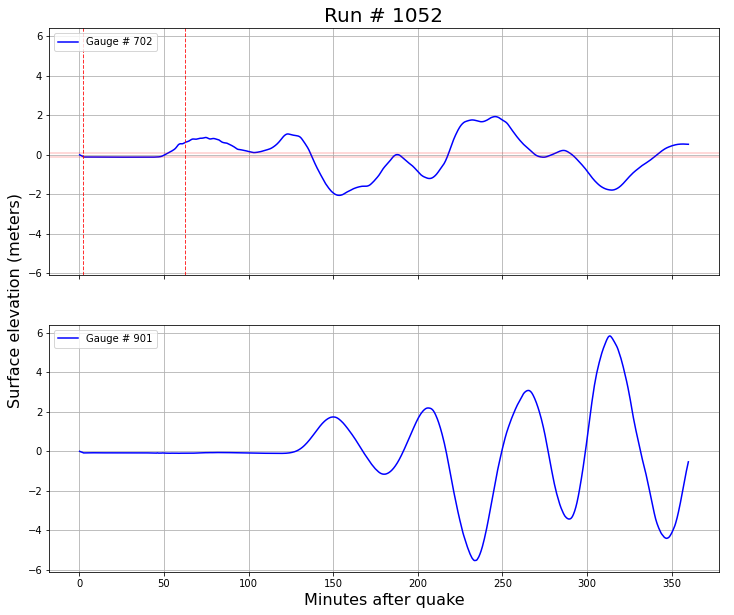

In [474]:
%matplotlib inline

plot_run(1052,901)

In [475]:
find_run(pred_901, test_901_target, test_901_runs, 1052)

Run not found.


In [476]:
# save_run_plots(badruns['Run Number'].tolist(), badruns['Predicted'].tolist(),901)

## Visualizing Significance

In [477]:
from tsfresh.feature_selection.relevance import calculate_relevance_table
from tsfresh import defaults, extract_features

In [478]:
FDR_LEVEL = defaults.FDR_LEVEL
HYPOTHESES_INDEPENDENT = defaults.HYPOTHESES_INDEPENDENT

In [479]:
index = pd.Series(range(1300))
feat702_relevance = pd.read_csv (r'feat702_all_910.csv')

In [480]:
df_pvalues_mann = calculate_relevance_table(feat702_relevance.set_index(index), pd.Series(max_eta_all(eta,901,1300)), 
                                            fdr_level=FDR_LEVEL, test_for_real_target_real_feature='mann')

In [481]:
feat702_relevance

,eta__abs_energy,eta__absolute_sum_of_changes,"eta__agg_autocorrelation__f_agg_""mean""__maxlag_40","eta__agg_autocorrelation__f_agg_""median""__maxlag_40","eta__agg_autocorrelation__f_agg_""var""__maxlag_40","eta__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""max""","eta__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""mean""","eta__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""min""","eta__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""var""","eta__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""max""",...,eta__spkt_welch_density__coeff_8,eta__standard_deviation,eta__sum_values,eta__symmetry_looking__r_0.05,eta__time_reversal_asymmetry_statistic__lag_1,eta__time_reversal_asymmetry_statistic__lag_2,eta__time_reversal_asymmetry_statistic__lag_3,eta__variance,eta__variance_larger_than_standard_deviation,eta__variation_coefficient
0,2.412246,0.679106,0.964136,0.973248,0.001101,0.000935,-0.000914,-0.002687,3.029241e-06,0.009132,...,3.841084e-06,0.033421,1.219225,1.0,1.017066e-11,3.619885e-11,4.578725e-11,0.001117,0.0,59.182217
1,13.370748,3.054860,0.868627,0.897225,0.013059,0.008716,0.002389,-0.003847,3.562167e-05,0.037286,...,3.728982e-05,0.078685,-2.847386,1.0,2.576779e-08,4.257236e-08,4.499135e-08,0.006191,0.0,-59.661858
2,0.331196,0.259946,0.965037,0.975029,0.001104,0.001598,0.001498,0.001406,3.566421e-08,0.002319,...,1.001003e-06,0.012382,-0.644902,1.0,-1.054159e-11,-2.748929e-11,-5.314523e-11,0.000153,0.0,-41.452304
3,0.640058,0.379195,0.943330,0.955231,0.002297,0.000310,0.000077,-0.000150,6.691218e-08,0.000783,...,9.502599e-07,0.017218,-0.213626,1.0,1.440807e-08,2.983190e-08,4.622280e-08,0.000296,0.0,-174.010635
4,0.025222,0.067010,0.968109,0.977516,0.000943,0.000441,0.000432,0.000424,6.418344e-10,0.000457,...,9.803306e-10,0.003413,-0.388539,1.0,1.981991e-12,3.836705e-12,5.530982e-12,0.000012,0.0,-18.966184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,1948.151775,18.598585,0.970711,0.978939,0.000774,0.149417,0.106535,0.064645,1.476783e-03,0.311533,...,1.236182e-03,0.948689,-104.193884,1.0,7.778036e-05,1.467181e-04,2.087964e-04,0.900011,0.0,-19.657771
1296,397.333034,11.667083,0.931686,0.940737,0.002730,0.031642,-0.017963,-0.063791,4.694734e-03,0.231862,...,1.958362e-03,0.428742,-31.726885,1.0,2.054656e-05,1.192284e-04,3.195020e-04,0.183820,0.0,-29.175700
1297,679.818634,14.975432,0.936493,0.946596,0.002644,0.047269,-0.016829,-0.072190,3.388180e-03,0.298513,...,3.767531e-03,0.561031,-23.749379,1.0,1.672917e-05,8.490341e-05,1.863580e-04,0.314756,0.0,-51.001990
1298,1009.078932,13.551831,0.967809,0.976695,0.000931,0.054127,0.019049,-0.015702,1.083996e-03,0.194561,...,5.505635e-04,0.683643,-8.430481,1.0,4.810649e-07,1.272088e-06,2.692250e-06,0.467367,0.0,-175.077140


In [482]:
df_pvalues_mann.head(10)

,feature,type,p_value,relevant
feature,,,,
eta__abs_energy,eta__abs_energy,real,0.0,True
"eta__change_quantiles__f_agg_""var""__isabs_False__qh_0.2__ql_0.0","eta__change_quantiles__f_agg_""var""__isabs_Fals...",real,0.0,True
"eta__change_quantiles__f_agg_""var""__isabs_False__qh_0.4__ql_0.0","eta__change_quantiles__f_agg_""var""__isabs_Fals...",real,0.0,True
"eta__change_quantiles__f_agg_""var""__isabs_False__qh_0.4__ql_0.2","eta__change_quantiles__f_agg_""var""__isabs_Fals...",real,0.0,True
"eta__change_quantiles__f_agg_""var""__isabs_False__qh_0.6__ql_0.0","eta__change_quantiles__f_agg_""var""__isabs_Fals...",real,0.0,True
"eta__change_quantiles__f_agg_""var""__isabs_False__qh_0.6__ql_0.2","eta__change_quantiles__f_agg_""var""__isabs_Fals...",real,0.0,True
"eta__change_quantiles__f_agg_""var""__isabs_False__qh_0.6__ql_0.4","eta__change_quantiles__f_agg_""var""__isabs_Fals...",real,0.0,True
"eta__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.0","eta__change_quantiles__f_agg_""var""__isabs_Fals...",real,0.0,True
"eta__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.2","eta__change_quantiles__f_agg_""var""__isabs_Fals...",real,0.0,True


[]

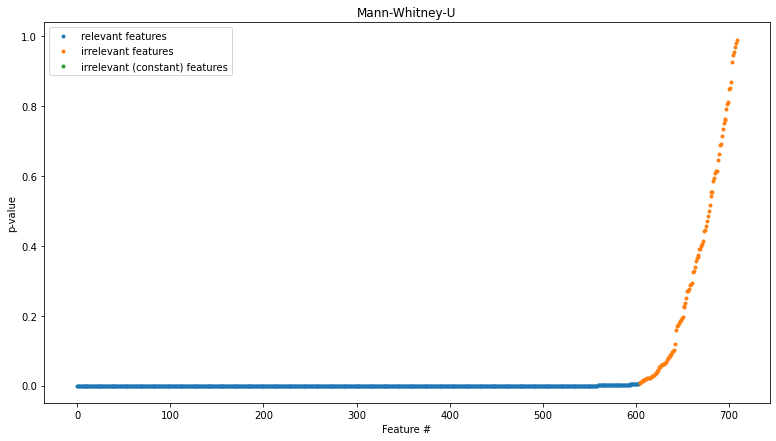

In [483]:
figure(figsize=(13,7))
df_pvalues_mann.index = pd.Series(range(0, len(df_pvalues_mann.index)))

df_pvalues_mann.p_value.where(df_pvalues_mann.relevant)\
    .plot(style=".", label="relevant features")

df_pvalues_mann.p_value.where(~df_pvalues_mann.relevant & (df_pvalues_mann.type != "const"))\
    .plot(style=".", label="irrelevant features")

df_pvalues_mann.p_value.fillna(1).where(df_pvalues_mann.type == "const")\
    .plot(style=".", label="irrelevant (constant) features")

plt.xlabel("Feature #")
plt.ylabel("p-value")
plt.title("Mann-Whitney-U")
plt.legend()
plt.plot()
